In [ ]:
!pip install transformers

In [ ]:
import cv2 as cv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

from gen_images import make_transform
import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from scipy import fftpack
from werkzeug.utils import secure_filename
import sklearn as sk
import legacy
from sklearn.cluster import KMeans


import io
import base64

from sklearn.decomposition import PCA

#network_pkl = "models/stylegan3-r-ffhq-1024x1024.pkl"
network_pkl = "models/stylegan3-r-afhqv2-512x512.pkl"
seeds = [1]
truncation_psi = 0.7
class_idx = None
noise_mode = "const"
outdir = "server_outputs"
translate = (0.0, 0.0)
rotate = 0.0
G = None

def generate_image(latent_vector):
    global G
    device = torch.device('cuda')
    if G is None:
        with dnnlib.util.open_url(network_pkl) as f:
            G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    os.makedirs(outdir, exist_ok=True)

    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    for seed_idx, seed in enumerate(seeds):
        z = torch.from_numpy(latent_vector).to(device)
        if hasattr(G.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G.synthesis.input.transform.copy_(torch.from_numpy(m))
        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        np_img = img[0].cpu().numpy()
        if len(np_img.shape) < 3 or np_img.shape[-1] < 3:
            np_img = np.stack([np_img[:, :, 0]]*3, axis=-1)
        return np_img
    


def find_palette(image, palette_size):
    #Save time, resize to 100x100
    image = cv.resize(image, (100, 100))

    pixels = np.float32(image.reshape(-1, 3))

    kmeans = KMeans(n_clusters=palette_size, random_state=42)
    kmeans.fit(pixels)

    palette = np.uint8(kmeans.cluster_centers_)
    return palette

def find_color_grid(img, grid_size=(3,3)):
    sx = img.shape[1] // grid_size[0]
    sy = img.shape[0] // grid_size[1]
    color_array = np.zeros((*grid_size, 3))
    for ix in range(grid_size[0]):
        for iy in range(grid_size[1]):
            start_x = ix*sx
            start_y = iy*sy
            end_x = start_x + sx
            end_y = start_y + sy
            field = img[start_y:end_y, start_x:end_x]
            primary_color = find_palette(field, 1)[0]
            color_array[iy, ix] = primary_color
    np_arr = np.array(color_array)
    return np_arr

In [ ]:
latent_a = np.random.normal(size=(1, 512), loc=0, scale=truncation_psi)
latent_b = np.random.normal(size=(1, 512), loc=0, scale=truncation_psi)

In [ ]:
def fuse_latents(latent_a, latent_b):
    interpolation_factors = np.linspace(0, 1, 512)
    imgs = []
    for i in interpolation_factors:
        latent_vector = (1-i)*latent_a + i*latent_b
        img = generate_image(latent_vector)
        imgs.append(img)

    dimswap = np.zeros((512, 512, 3))
    for i in range(512):
        dimswap[:, i] = imgs[i][:, i]
    return dimswap, np.array(imgs)

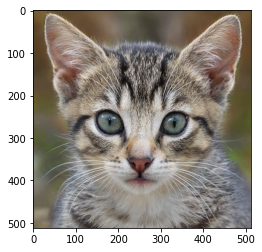

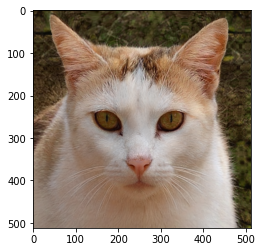

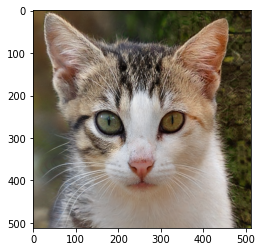

In [302]:
plt.imshow(generate_image(latent_a))
plt.show()
plt.imshow(generate_image(latent_b))
plt.show()
img = fuse_latents(latent_a, latent_b)[0]/255.0
plt.imshow(img)

In [308]:
cv.imwrite("cat_mix.png", img[:, :, ::-1]*255)
cv.imwrite("cat_1.png", generate_image(latent_a)[:,:, ::-1])
cv.imwrite("cat_2.png", generate_image(latent_b)[:,:, ::-1])

True

In [ ]:
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install IProgress

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



def smart_search(initial_latent, target_index, classes=["dog", "cat"], min_steps = 5, init_noise_scale=0.5, min_score=0.5, debug=True):
    best_score = None
    best_latent = None
    
    noise_scale = init_noise_scale
    
    searching = True
    steps_taken = 0

    images, latents = [], []

    while steps_taken < min_steps or (best_score is not None and best_score < min_score):
        # Choose a very small random vector as step
        noise = np.random.normal(loc=0, scale=noise_scale, size=(1, 512))
        noisy_latent = initial_latent + noise

        noisy_image = generate_image(noisy_latent)
        noisy_fullscale_image = noisy_image.copy()
        noisy_image = cv.resize(noisy_image, (512, 512))
        
        inputs = processor(text=classes, images=np.array([noisy_image]), return_tensors="pt", padding=True)
        all_logits = model(**inputs).logits_per_image.softmax(1).detach().numpy()
        score = all_logits[0][target_index]

        if best_latent is None or score > best_score:
            best_score = score
            best_latent = noisy_latent
            images.append(noisy_fullscale_image)
            latents.append(noisy_latent)
            initial_latent = best_latent
            noise_scale = noise_scale * 0.99
            steps_taken += 1
            if debug:
                print("Best score so far: ", best_score)
                plt.imshow(noisy_fullscale_image)
                plt.show()
        else:
            noise_scale *= 1.0001
    return latents[-1]
        

In [309]:
cat_latent = smart_search(np.random.normal(size=(1,512), loc=0, scale=truncation_psi), 0, classes = ["cute house cat", "domestic dog"], init_noise_scale=0.1, debug=False)

In [310]:
lion_latent = smart_search(np.random.normal(size=(1,512), loc=0, scale=truncation_psi), 0, classes = ["elegant lion", "house cat", "panther", "leopard"], init_noise_scale=0.1, debug=False)

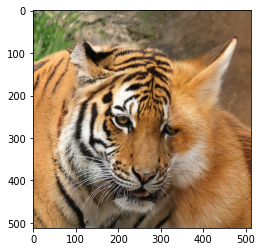

In [311]:
cat_lion, latent_collection = fuse_latents(cat_latent, lion_latent)
plt.imshow(cat_lion/255.0)

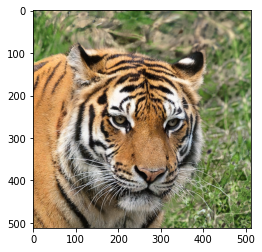

In [312]:
plt.imshow(generate_image(cat_latent)/255.0)

In [328]:
def get_random_height_level():
    height_level = np.zeros((512, 512))
    base_noise_size = 3
    noise_size = 1
    all_noise = np.zeros_like(height_level)
    for i in range(100):
        current_noise_size = min(int(base_noise_size/noise_size), 512)
        noise = np.random.normal(size=(current_noise_size, current_noise_size), loc=0.0, scale=noise_size*0.3)
        #noise *= abs(noise)
        all_noise += cv.resize(noise, (512, 512))
        noise_size *= 0.75
        all_noise /= max(np.max(all_noise), -1*np.min(all_noise))
    noise_importance = 1
    integer_height_level = np.uint8(cv.blur(125 + int(125*noise_importance)*all_noise, (3, 3)))
    return integer_height_level

In [337]:
rnd_noise = get_random_height_level()
other_noise = rnd_noise*-1

video = []
video_noises = []
for f in np.linspace(0, 1, 60):
    video_noises.append(rnd_noise*(1-f) + other_noise*f)

for current_noise in video_noises:
    noisy_mix = np.zeros((512, 512, 3))
    for x in range(512):
        for y in range(512):
            noisy_mix[y, x] = latent_collection[np.uint8(current_noise[y, x]), y, x]
    video.append(noisy_mix)
    if len(video_noises) < 100:
        video_noises.append(np.clip(video_noises[-1] + np.random.normal(size=(512, 512), loc=0.0, scale=1.1), 0, 1))
    #plt.imshow(noisy_mix/255.0)
    #plt.show()
    #plt.imshow(rnd_noise)

In [338]:
out = cv.VideoWriter("noisy-walk-test2.avi", cv.VideoWriter_fourcc(*"MJPG"), 5,(512,512))
for frame in video:
    out.write(frame[:, :, ::-1].astype('uint8'))
out.release()

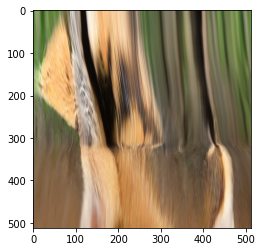

In [343]:
# Random experiment
exp_imgs = []
out = cv.VideoWriter("experimental_walk.avi", cv.VideoWriter_fourcc(*"MJPG"), 10,(512,512))
for i in range(512):
    #print(latent_collection[:, i, :].shape)
    out.write(latent_collection[:, i, :][:, :, ::-1])
out.release()